In [2]:
from collections import defaultdict

import numpy as np
import pandas as pd


In [3]:
foursquare_nyc_geo_path = 'raw_data/foursquare_nyc/foursquare_nyc.geo'
foursquare_nyc_dyna_path = "raw_data/foursquare_nyc/foursquare_nyc.dyna"
geo_data = pd.read_csv(foursquare_nyc_geo_path)
dyna_data = pd.read_csv(foursquare_nyc_dyna_path)
geo_data.head()

,geo_id,type,coordinates,venue_category_id,venue_category_name
0,0,Point,"[-74.00313913822173,40.73359624463057]",4bf58dd8d48988d1e7931735,Music Venue
1,1,Point,"[-73.97573416870671,40.75810221550426]",4bf58dd8d48988d176941735,Gym / Fitness Center
2,2,Point,"[-74.00309176330678,40.65276619423542]",4bf58dd8d48988d1e4931735,Bowling Alley
3,3,Point,"[-73.98003864274011,40.72696058176322]",4bf58dd8d48988d118941735,Bar
4,4,Point,"[-73.96764401966811,40.75636758214827]",4bf58dd8d48988d11d941735,Bar


In [23]:
dyna_data.head()

,dyna_id,type,time,entity_id,location
0,0,trajectory,2012-04-03T14:00:09Z,0,2388
1,1,trajectory,2012-04-03T14:00:25Z,1,3921
2,2,trajectory,2012-04-03T14:02:24Z,2,20328
3,3,trajectory,2012-04-03T14:02:41Z,3,15114
4,4,trajectory,2012-04-03T14:03:00Z,4,23550


In [10]:
# filter the poi has not been checked in less than threhold times
def filter_location_checkin(df, threshold=5):
    venue_counts = df['location'].value_counts()
    filtered_venues = venue_counts[venue_counts >= threshold].index
    df = df[df['location'].isin(filtered_venues)]
    return df

In [13]:
dyna_data_filtered = filter_location_checkin(dyna_data,threshold=0)
dyna_data_filtered

,dyna_id,type,time,entity_id,location
0,0,trajectory,2012-04-03T14:00:09Z,0,2388
1,1,trajectory,2012-04-03T14:00:25Z,1,3921
2,2,trajectory,2012-04-03T14:02:24Z,2,20328
3,3,trajectory,2012-04-03T14:02:41Z,3,15114
4,4,trajectory,2012-04-03T14:03:00Z,4,23550
...,...,...,...,...,...
227423,227423,trajectory,2013-02-15T21:29:11Z,136,0
227424,227424,trajectory,2013-02-15T21:31:35Z,535,15284
227425,227425,trajectory,2013-02-15T21:33:16Z,729,37855
227426,227426,trajectory,2013-02-15T21:34:31Z,1065,1773


In [28]:
def frequency_of_occurrence(df, hours_gap=None):
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values(by=['entity_id', 'time'])
    
    if hours_gap:
        df['sequence_gap'] = df.groupby('entity_id')['time'].diff().gt(pd.Timedelta(hours=hours_gap))

        df['sequence_id'] = df.groupby('entity_id')['sequence_gap'].cumsum().fillna(0)
    else:
        df['sequence_id'] = 0  # If no hours_gap, use a single sequence for each user
        
    pairwise_counts = defaultdict(int)
    grouped = df.groupby(['entity_id', 'sequence_id'])['location'].apply(list).reset_index()
    for _, row in grouped.iterrows():
        venues_list = row['location']

        for i, v1 in enumerate(venues_list):
            for j, v2 in enumerate(venues_list):
                if i < j:  # To ensure we only count when v1 appears before v2
                    pairwise_counts[(v1, v2)] +=  1
    venues = df['location'].unique()
    n = len(venues)
    matrix = np.zeros((n, n))
    for (i, j), count in pairwise_counts.items():
 
        fraction = count / len(grouped)
        matrix[i, j] = fraction  # Asymmetric matrix     
        
    # print(matrix)
    
    return matrix

In [29]:
freq_matrix = frequency_of_occurrence(dyna_data_filtered)
freq_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
freq_matrix.shape

(38333, 38333)

e:\Anaconda\envs\deeplearning\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\deeplearning\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 38453 (\N{CJK UNIFIED IDEOGRAPH-9635}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\deeplearning\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\deeplearning\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\deeplearning\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.c

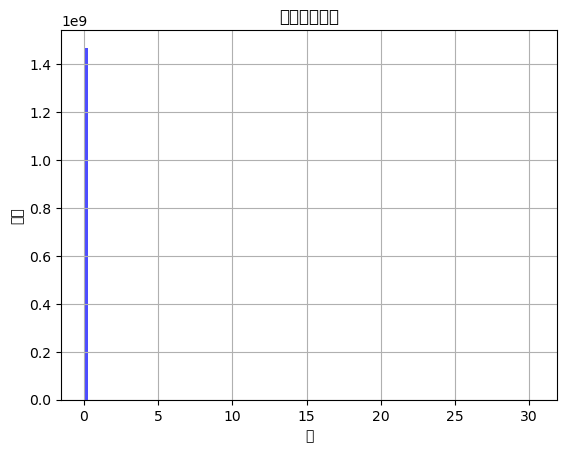

In [40]:
import matplotlib.pyplot as plt


# 将矩阵展平为1D数组
values = freq_matrix.flatten()

# 绘制直方图，使用更多的bins来查看接近0的值的分布
plt.hist(values, bins=100, color='blue', alpha=0.7)
plt.title('矩阵值的分布')
plt.xlabel('值')
plt.ylabel('频率')
plt.grid(True)
plt.show()


In [39]:
freq_matrix[2388][27701]

0.0009233610341643582

In [44]:
np.load('clean_data/foursquare_nyc/freq_matrix.npy')[2388][27701]

3.138633439000659e-05

In [15]:

data = {
    'entity_id': [0, 1, 0, 1, 1, 0, 2, 2],
    'location': [2, 2, 0, 1, 3, 2, 4, 3],
    'time': ['2012-04-03T14:00:09Z', '2012-04-03T14:00:25Z', '2012-04-03T14:00:29Z',
             '2012-04-03T14:00:35Z', '2012-04-03T14:00:45Z', '2012-04-03T14:01:25Z',
             '2012-04-03T14:02:25Z', '2012-04-03T14:03:25Z']
}


df = pd.DataFrame(data)
df.sort_values

def frequency_of_occurrence(df, hours_gap=None):
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values(by=['entity_id', 'time'])
    if hours_gap:
        df['sequence_gap'] = df.groupby('entity_id')['time'].diff().gt(pd.Timedelta(hours=hours_gap))

        df['sequence_id'] = df.groupby('entity_id')['sequence_gap'].cumsum().fillna(0)
    else:
        df['sequence_id'] = 0  # If no hours_gap, use a single sequence for each user

    pairwise_counts = defaultdict(int)
    grouped = df.groupby(['entity_id', 'sequence_id'])['location'].apply(list).reset_index()
    for _, row in grouped.iterrows():
        venues_list = row['location']

        for i, v1 in enumerate(venues_list):
            for j, v2 in enumerate(venues_list):
                if i < j:  # To ensure we only count when v1 appears before v2
                    pairwise_counts[(v1, v2)] += 1
    venues = df['location'].unique()
    n = len(venues)
    matrix = np.zeros((n, n))
    for (i, j), count in pairwise_counts.items():
        fraction = count / len(grouped)
        matrix[i, j] = fraction  # Asymmetric matrix

    return matrix


ff = frequency_of_occurrence(df)
ff

   entity_id  location                      time
0          0         2 2012-04-03 14:00:09+00:00
2          0         0 2012-04-03 14:00:29+00:00
5          0         2 2012-04-03 14:01:25+00:00
1          1         2 2012-04-03 14:00:25+00:00
3          1         1 2012-04-03 14:00:35+00:00
4          1         3 2012-04-03 14:00:45+00:00
6          2         4 2012-04-03 14:02:25+00:00
7          2         3 2012-04-03 14:03:25+00:00


array([[0.        , 0.        , 0.33333333, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.33333333, 0.        ],
       [0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.33333333, 0.        ]])

In [14]:
# 1 前 3 后
ff[1][3]

0.3333333333333333

In [53]:
coordinates = df['coordinates']

In [62]:
from geographiclib.geodesic import Geodesic
coordinate = [eval(coord) for coord in df['coordinates']]
lats = [float(coord[1]) for coord in coordinate]
lons = [float(coord[0]) for coord in coordinate]
dist_angle_mat = np.zeros((len(lons), len(lons), 2))
for i in range(len(coordinates)):
        for j in range(len(coordinates)):
            dist = Geodesic.WGS84.Inverse(lats[i], lons[i], lats[j], lons[j])
            dist_angle_mat[i, j, 0] = dist["s12"] / 1000.0  # distance, km
            dist_angle_mat[i, j, 1] = dist["azi1"]  
            print(dist["azi1"],dist["azi2"])
print(dist_angle_mat.shape)

180.0 180.0
40.372666348518884 40.39055370616972
0.5717283972656164 0.5899782381532065
1.1475799191971416 1.1656485026049377
-139.60944629383027 -139.6273336514811
180.0 180.0
0.0 0.0
0.0 0.0
-179.4100217618468 -179.42827160273438
180.0 180.0
180.0 180.0
180.0 180.0
-178.83435149739506 -178.85242008080286
180.0 180.0
0.0 0.0
180.0 180.0
(4, 4, 2)


In [60]:
dist_angle_mat

array([[[   0.        ,  180.        ],
        [   3.5725326 ,   40.37266635],
        [ 224.87011863,    0.5717284 ],
        [ 113.80345182,    1.14757992]],

       [[   3.5725326 , -139.60944629],
        [   0.        ,  180.        ],
        [ 222.13720494,    0.        ],
        [ 111.05890405,    0.        ]],

       [[ 224.87011863, -179.41002176],
        [ 222.13720494,  180.        ],
        [   0.        ,  180.        ],
        [ 111.07830089,  180.        ]],

       [[ 113.80345182, -178.8343515 ],
        [ 111.05890405,  180.        ],
        [ 111.07830089,    0.        ],
        [   0.        ,  180.        ]]])